In [37]:
#modules for dataset and other basics. may need to install datasets library.
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

#modules for text preprocessing
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

#count vectorizer and wordnet lemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

#stopwords (we will remove these from the text data)
from nltk.corpus import stopwords

#word cloud for visualization
from wordcloud import WordCloud as wc

#sentence transformers for the pretrained embedding model
from sentence_transformers import SentenceTransformer

#keras functions for the model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Masking, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Embedding
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

#metrics for model evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [38]:
liar = load_dataset('liar') #load the liar dataset from the datasets library. same as what we had from kaggle.

In [39]:
#conveniently pre-split into train, test, and val sets! we'll just use the statement and label columns.

train = liar['train'].to_pandas()[['label', 'statement']]
test = liar['test'].to_pandas()[['label', 'statement']]
val = liar['validation'].to_pandas()[['label', 'statement']]

In [40]:
print(train.head())

   label                                          statement
0      0  Says the Annies List political group supports ...
1      1  When did the decline of coal start? It started...
2      2  Hillary Clinton agrees with John McCain "by vo...
3      0  Health care reform legislation is likely to ma...
4      1  The economic turnaround started at the end of ...


In [41]:
#drop duplicates
train.drop_duplicates(subset='statement', keep='first', inplace=True)
test.drop_duplicates(subset='statement', keep='first', inplace=True)
val.drop_duplicates(subset='statement', keep='first', inplace=True)

d:\Anaconda\envs\ds\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


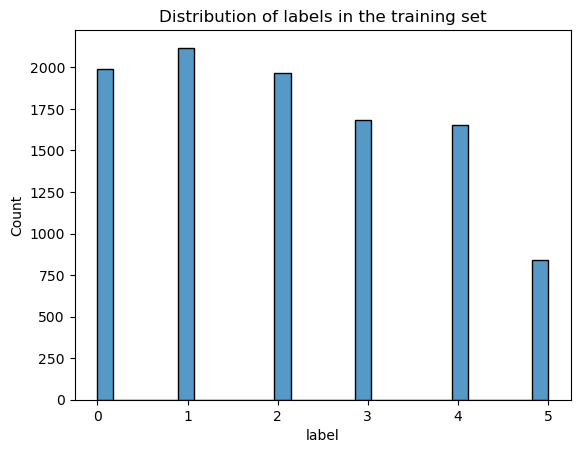

In [42]:
sns.histplot(train['label'])
plt.title('Distribution of labels in the training set')
plt.show()

d:\Anaconda\envs\ds\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


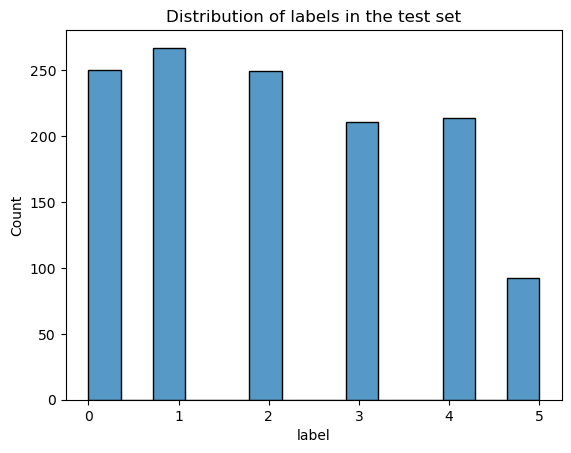

In [43]:
sns.histplot(test['label'])
plt.title('Distribution of labels in the test set')
plt.show()

d:\Anaconda\envs\ds\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


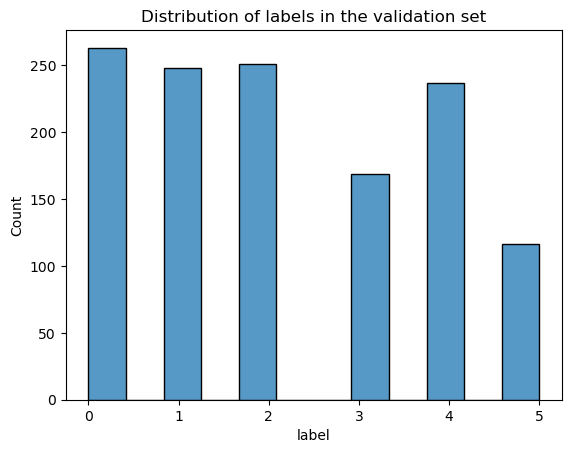

In [44]:
sns.histplot(val['label'])
plt.title('Distribution of labels in the validation set')
plt.show()

In [45]:
stopwords = set(stopwords.words('english')) #set up stopwords

In [46]:
def tokenise_lemmatize(text):
    
    text = re.sub(r'[^\w\s]', '', text) #remove punctuation
    text = text.lower() #lowercase

    tokens = text.split() #tokenise

    tokens = [token for token in tokens if token not in stopwords] #remove stopwords
    
    lemmatizer = WordNetLemmatizer()
    tokens = " ".join(lemmatizer.lemmatize(token) for token in tokens) #lemmatise
    return tokens

In [47]:
train['statement'] = train['statement'].apply(tokenise_lemmatize)
test['statement'] = test['statement'].apply(tokenise_lemmatize)
val['statement'] = val['statement'].apply(tokenise_lemmatize)

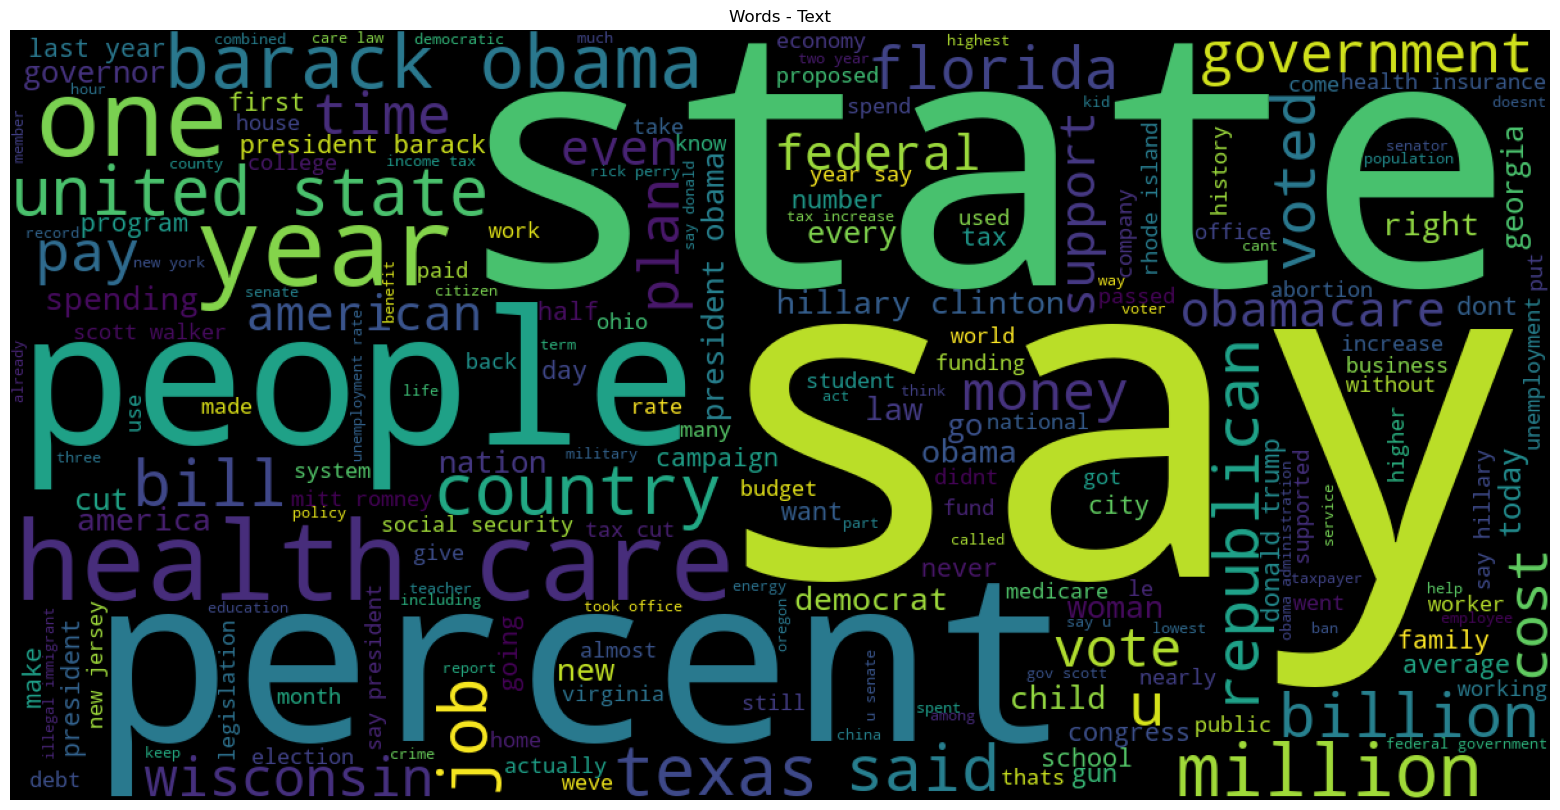

In [48]:
words_text = " ".join([word for word in train["statement"]]) #word cloud for text
word_cloud_text = wc(width=1200, height=600).generate(words_text)
plt.figure(figsize=(20, 10))
plt.imshow(word_cloud_text)
plt.title("Words - Text")
plt.axis("off")
plt.show()

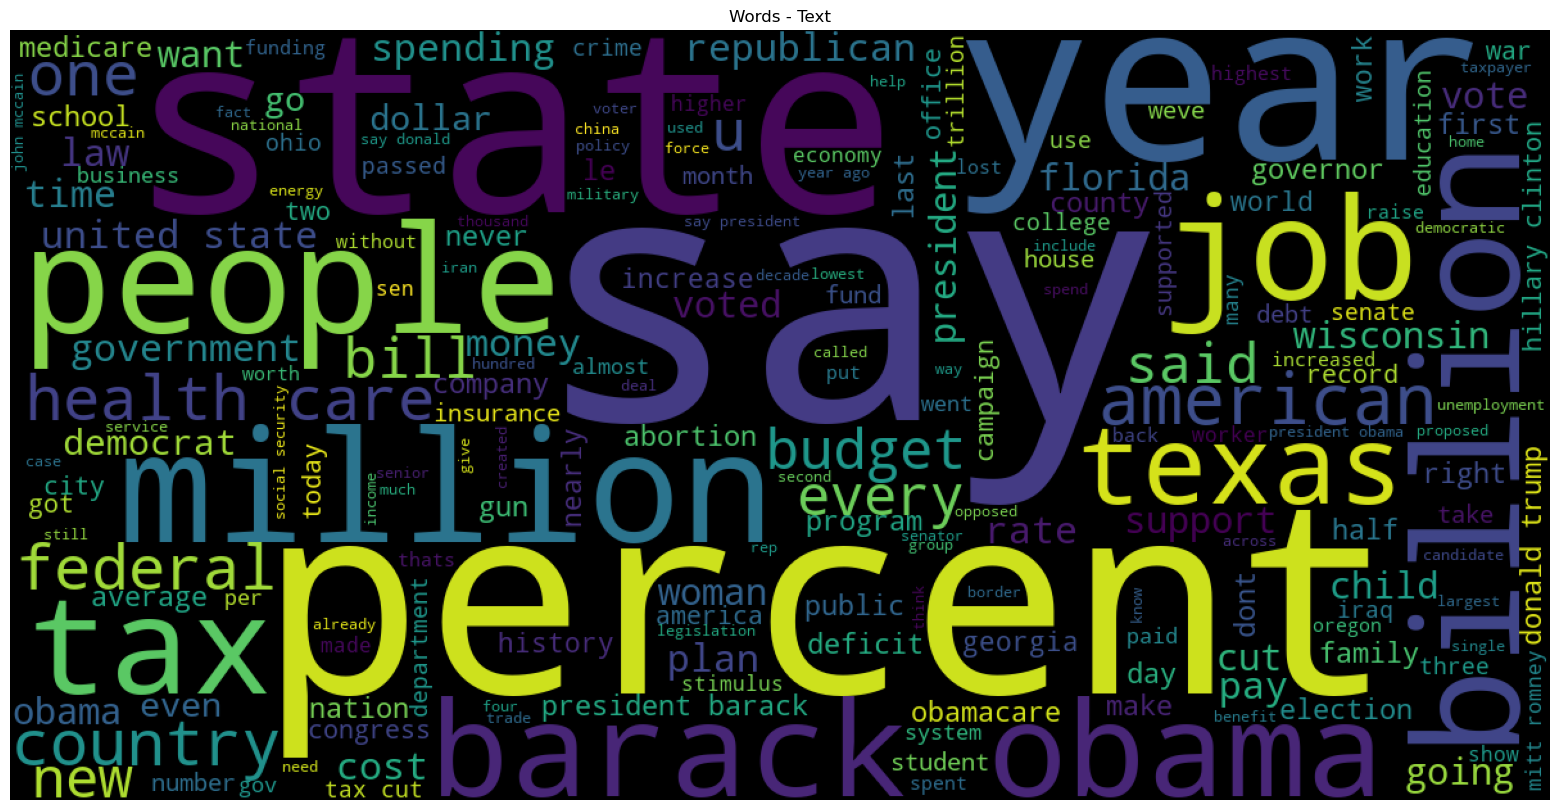

In [49]:
words_text = " ".join([word for word in test["statement"]]) #word cloud for text
word_cloud_text = wc(width=1200, height=600).generate(words_text)
plt.figure(figsize=(20, 10))
plt.imshow(word_cloud_text)
plt.title("Words - Text")
plt.axis("off")
plt.show()

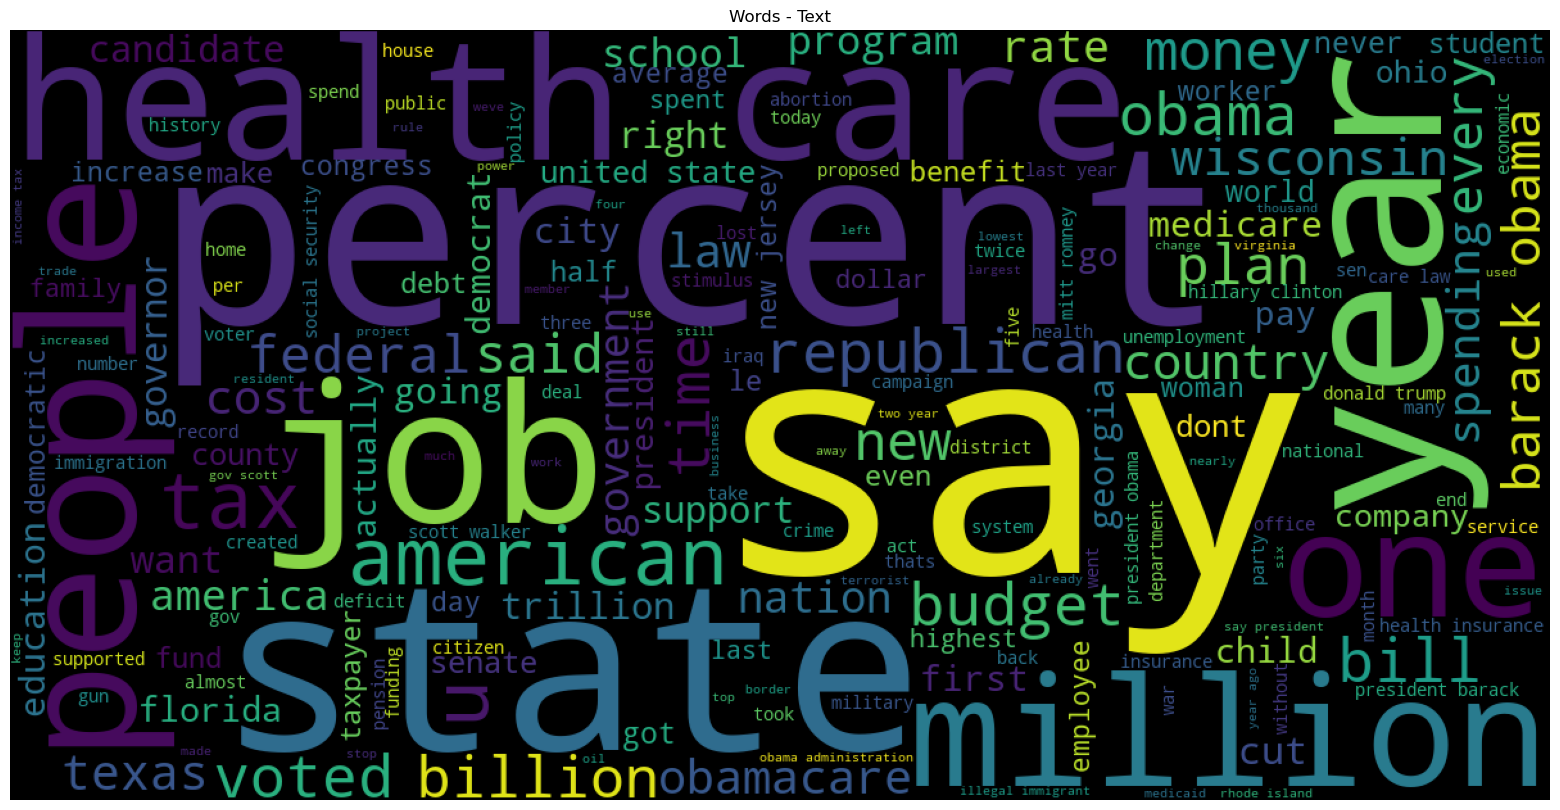

In [50]:
words_text = " ".join([word for word in val["statement"]]) #word cloud for text
word_cloud_text = wc(width=1200, height=600).generate(words_text)
plt.figure(figsize=(20, 10))
plt.imshow(word_cloud_text)
plt.title("Words - Text")
plt.axis("off")
plt.show()

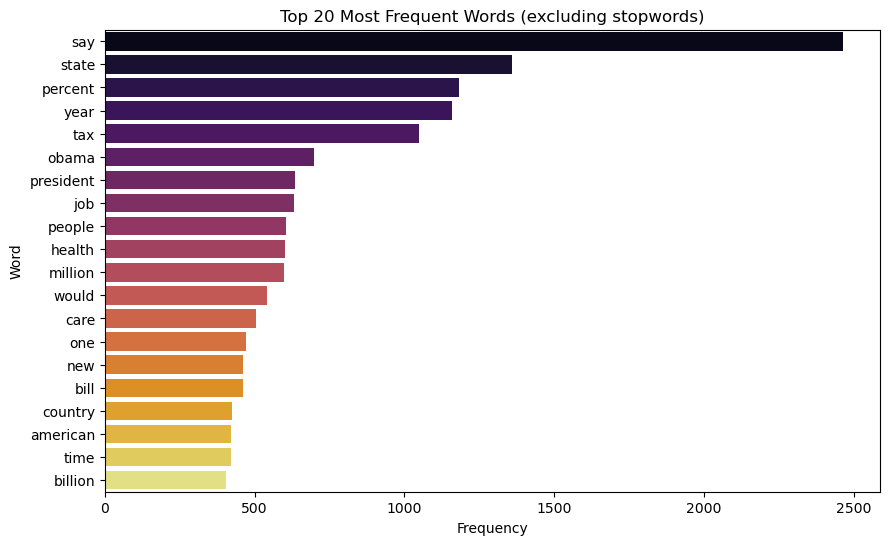

In [51]:
#graph to show the most common words
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train['statement'])

word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

word_freq_sum = word_freq.sum(axis=0).sort_values(ascending=False)[:20]
plt.figure(figsize=(10, 6))
sns.barplot(x=word_freq_sum.values, y=word_freq_sum.index, palette='inferno')
plt.title('Top 20 Most Frequent Words (excluding stopwords)')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

In [52]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2') #the embedding model- going with MiniLM for now coz it's a popular choice

d:\Anaconda\envs\ds\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [53]:
#does embedding and padding from sentences conveniently!
train_embeddings = embedding_model.encode(train['statement'].values, show_progress_bar=True, convert_to_numpy=True, output_value='token_embeddings')
test_embeddings = embedding_model.encode(test['statement'].values, show_progress_bar=True, convert_to_numpy=True, output_value='token_embeddings')
val_embeddings = embedding_model.encode(val['statement'].values, show_progress_bar=True, convert_to_numpy=True, output_value='token_embeddings')

Batches:   0%|          | 0/321 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

In [54]:
#pad it just in case lol
train_embeddings = pad_sequences(train_embeddings, padding='post', dtype='float32')
test_embeddings = pad_sequences(test_embeddings, padding='post', dtype='float32')
val_embeddings = pad_sequences(val_embeddings, padding='post', dtype='float32')

In [55]:
#one-hot encode the labels
train_labels = to_categorical(train['label'])
test_labels = to_categorical(test['label'])
val_labels = to_categorical(val['label'])

In [56]:
vocab_size = embedding_model.tokenizer.vocab_size

model = Sequential()

model.add(Input(shape=(train_embeddings.shape[1],train_embeddings.shape[2]))) #input layer

model.add(Masking(mask_value=0.0)) #masking layer- to ignore the padding

model.add(Bidirectional(LSTM(96, kernel_regularizer='l2', dropout=0.5, recurrent_dropout=0.4))) #bidirectional LSTM layer, dropout and regularisation to prevent overfitting

model.add(Dense(64, activation='tanh')) #feature selection layer- could be a positive or negative sentiment, so went with tanh

model.add(Dense(32, activation='tanh')) #same logic, narrowing down the features

model.add(Dense(6, activation='softmax')) #output layer- 6 classes, so softmax activation to ensure the output adds up to 1 (like probabilities)

In [57]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #went with popular choices for the optimizer and loss function, got it from the papers

print(model.summary()) #always helps to print the summary.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 54, 384)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 192)            │       369,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,038 (1.46 MB)

 Trainable params: 384,038 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

None


In [58]:
model.fit(train_embeddings, train_labels, validation_data=(val_embeddings, val_labels), epochs=50, callbacks=[ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.1, verbose=1), EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)])

'''
fit for 50 epochs. validation set provided.
two interesting callback functions-
ReduceLROnPlateau reduces the learning rate by <factor> if the <monitor> metric doesn't improve after <patience> number of epochs
EarlyStopping stops the training if the <monitor> metric doesn't improve after <patience> number of epochs.
'''

Epoch 1/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.2100 - loss: 4.5921 - val_accuracy: 0.2539 - val_loss: 1.8589 - learning_rate: 0.0010
Epoch 2/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.2481 - loss: 1.8266 - val_accuracy: 0.2516 - val_loss: 1.7717 - learning_rate: 0.0010
Epoch 3/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.2540 - loss: 1.7743 - val_accuracy: 0.2625 - val_loss: 1.7651 - learning_rate: 0.0010
Epoch 4/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.2520 - loss: 1.7727 - val_accuracy: 0.2539 - val_loss: 1.7811 - learning_rate: 0.0010
Epoch 5/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2437 - loss: 1.7691
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
321/321 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.2437 - loss: 1.7691 - val_accuracy: 0.2375 - val_loss: 1.7750 - learning_rate: 0.0010
Epoch 6/50
321/321 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.2738 - lo

"\nfit for 50 epochs. validation set provided.\ntwo interesting callback functions-\nReduceLROnPlateau reduces the learning rate by <factor> if the <monitor> metric doesn't improve after <patience> number of epochs\nEarlyStopping stops the training if the <monitor> metric doesn't improve after <patience> number of epochs.\n"

In [59]:
y_pred = model.predict(test_embeddings)
y_pred = np.argmax(y_pred, axis=1) #extracts the prediction from the one-hot encoded output
y_true = np.argmax(test_labels, axis=1)

print(classification_report(y_true, y_pred)) #print general stats

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

           0       0.26      0.40      0.32       250
           1       0.27      0.43      0.33       267
           2       0.28      0.33      0.30       249
           3       0.26      0.12      0.16       211
           4       0.27      0.10      0.14       214
           5       0.33      0.05      0.09        92

    accuracy                           0.27      1283
   macro avg       0.28      0.24      0.22      1283
weighted avg       0.27      0.27      0.25      1283



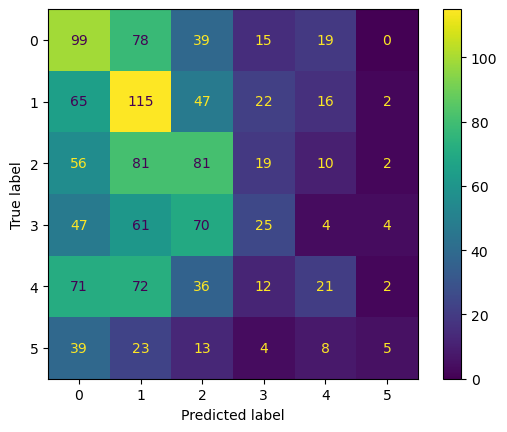

In [60]:
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot() #plot confusion matrix
plt.show()